## Classify Images of Colon Cancer

isCancerous classification: Binary classification to detect whether a given colon cell image is cancerous or not.

cellType classification: Multi-class classification to categorize the cell type (e.g., fibroblast, epithelial, etc.).

### Step 1: Import Libraries and Set Device

In [1]:
import os
import optuna
import random
import pandas as pd
import numpy as np
import torch
import seaborn as sns
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Dataset Description

In this project, we utilized a colon histology image dataset accompanied by two different CSV files, each catering to a specific classification task. These CSVs and the associated image data formed the foundation for building, training, and evaluating machine learning models for both binary and multiclass classification.

1. CSV for Binary Classification (isCancerous)

Purpose: To train a model that predicts whether a given colon histology image is cancerous or not.

CSV Columns:

    ImageName: The filename of the image (e.g., img_001.png)

    isCancerous: Binary label

        0 – Non-cancerous
        1 – Cancerous

2. CSV for Multiclass Classification (cellType)

Purpose: To train a model that classifies images into one of four cell types.

CSV Columns:

    ImageName: The filename of the image

    cellType: Multiclass label (integer from 0 to 3), representing:

        0 – Fibroblast

        1 – Inflammatory

        2 – Epithelial

        3 – Others




### Step 2: Load CSV Data and Data Split

In [3]:
# Paths
main_csv = r'data_labels_mainData.csv'
extra_csv = r'data_labels_extraData.csv'
image_dir = r'patch_images'  # Update if image path is different

# Load CSVs
data_main = pd.read_csv(main_csv)
data_extra = pd.read_csv(extra_csv)

# For reference: check columns
print(data_main.columns)
print(data_extra.columns)

Index(['InstanceID', 'patientID', 'ImageName', 'cellTypeName', 'cellType',
       'isCancerous'],
      dtype='object')
Index(['InstanceID', 'patientID', 'ImageName', 'isCancerous'], dtype='object')


#### Dataset Distribution

    Binary task (isCancerous)

        Classes: 0 (Non-cancerous), 1 (Cancerous)

Stratified split ensures class balance in train/val/test

#### Multi-class task (cellType)

    Classes: Multiple (e.g., fibroblast, epithelial, etc.)

Handled via label mapping and stratified splits to maintain proportional representation.

### Class Distribution

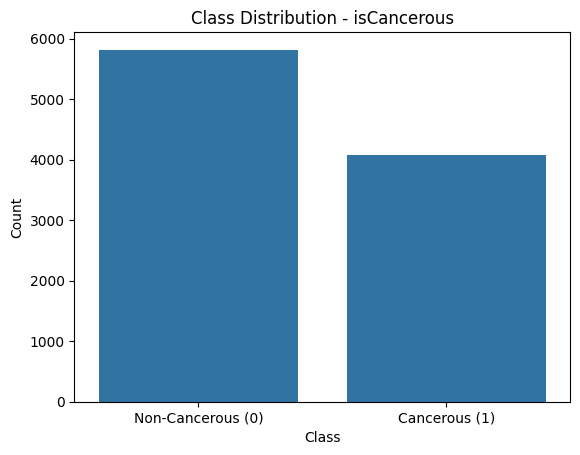

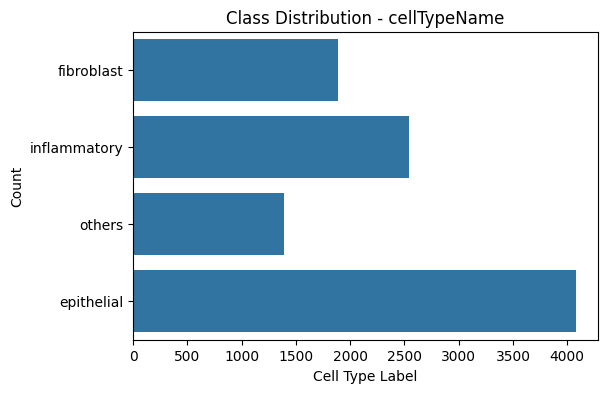

In [4]:
# Class distribution for isCancerous
sns.countplot(x='isCancerous', data=data_main)
plt.title('Class Distribution - isCancerous')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Cancerous (0)', 'Cancerous (1)'])  # Optional: better labels
plt.show()

# Class distribution for cellTypeName
plt.figure(figsize=(6, 4))
sns.countplot(data_main['cellTypeName'])
plt.title("Class Distribution - cellTypeName")
plt.xlabel("Cell Type Label")
plt.ylabel("Count")
plt.show()

Cancerous cells (label = 1) had significantly fewer samples compared to non-cancerous ones (label = 0). Similarly, certain cell types like Epithelial were more frequent than Others or Fibroblasts.

Implications:

    Models tend to bias towards the majority class, resulting in poor performance (e.g., lower recall) on minority classes.

    It affects overall model generalizability, especially in real-world settings where rare classes (e.g., cancerous cases) are clinically significant.


In [5]:
# Data Split

# For isCancerous model
df_cancer = data_main[['ImageName', 'isCancerous']]
train_df_cancer, val_df_cancer = train_test_split(df_cancer, test_size=0.2, stratify=df_cancer['isCancerous'], random_state=42)
test_df_cancer = data_extra[['ImageName', 'isCancerous']]

# For cellType model
train_df_type, temp_df = train_test_split(data_main, test_size=0.3, stratify=data_main['cellType'], random_state=42)
val_df_type, test_df_type = train_test_split(temp_df, test_size=0.5, stratify=temp_df['cellType'], random_state=42)

The dataset was divided into training, validation, and test sets using a stratified splitting strategy. For the isCancerous classification task, an 80/20 split was applied to the main dataset to form the training and validation sets, ensuring balanced class distribution. The extra dataset was used as an independent test set to assess generalization. For the cellType classification, the main dataset was split into 70% training, 15% validation, and 15% testing using stratified sampling based on cell type labels. This approach maintains label proportions across all splits and ensures robust model evaluation.

#### Sample Data from each class - Task 1

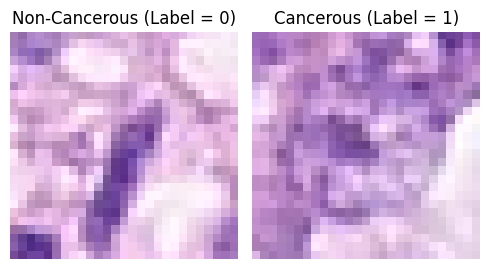

In [6]:
# Find one sample each for cancerous and non-cancerous
cancerous_row = data_extra[data_extra['isCancerous'] == 1].iloc[0]
non_cancerous_row = data_extra[data_extra['isCancerous'] == 0].iloc[0]

# Load images
cancerous_img = Image.open(os.path.join(image_dir, cancerous_row['ImageName']))
non_cancerous_img = Image.open(os.path.join(image_dir, non_cancerous_row['ImageName']))

# Plot
plt.figure(figsize=(5, 5))

plt.subplot(1, 2, 1)
plt.imshow(non_cancerous_img)
plt.title("Non-Cancerous (Label = 0)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cancerous_img)
plt.title("Cancerous (Label = 1)")
plt.axis('off')

plt.tight_layout()
plt.show()

#### Sample Data from each class - Task 2

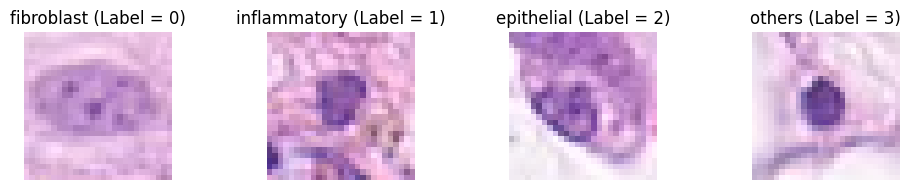

In [7]:
# Map of cell types and their labels
cell_type_map = {
    0: "fibroblast",
    1: "inflammatory",
    2: "epithelial",
    3: "others"
}

# Prepare to store image data
images = []
titles = []

# Loop through each cell type and load the first available image
for label, name in cell_type_map.items():
    row = data_main[data_main['cellType'] == label]
    if not row.empty:
        image_path = os.path.join(image_dir, row.iloc[0]['ImageName'])
        img = Image.open(image_path)
        images.append(img)
        titles.append(f"{name} (Label = {label})")
    else:
        print(f"No images found for label {label} ({name})")

# Plot the available images
if images:
    plt.figure(figsize=(2.5 * len(images), 2))
    for idx, (img, title) in enumerate(zip(images, titles), start=1):
        plt.subplot(1, len(images), idx)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No images found for any cell type.")

Sample images were visualized from both cancerous vs. non-cancerous and cell type categories. This helped identify potential data quality issues:

    Blurred images: Some samples lacked sharpness, affecting feature extraction.

    Occlusion: Certain cells were partially hidden behind others or image artifacts.

    Embedded text: A few images contained overlaid text or labels, which could confuse the model if not handled properly.

### Step 3: Custom Dataset Class

In [8]:
# Dataset Class
class ColonDataset(Dataset):
    def __init__(self, df, image_folder, label_type='isCancerous', transform=None):
        self.df = df.reset_index(drop=True)
        self.image_folder = image_folder
        self.transform = transform
        self.label_type = label_type

        if label_type == 'cellType':
            self.labels = sorted(self.df['cellType'].unique())
            self.label_map = {label: idx for idx, label in enumerate(self.labels)}
        else:
            self.label_map = None

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_folder, row['ImageName'])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        if self.label_type == 'cellType':
            label = torch.tensor(self.label_map[row['cellType']], dtype=torch.long)
        else:
            label = torch.tensor(row['isCancerous'], dtype=torch.long)

        return image, label

### Step 4: Transforms & DataLoader

This transformation pipeline converts images to PyTorch tensors and normalizes pixel values to a range of [-1, 1] using a mean and standard deviation of 0.5 for each RGB channel. This helps stabilize training by ensuring consistent input distribution across the dataset.

In [9]:
# Transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])


# Dataloaders
image_folder = r"patch_images"

# isCancerous
train_loader_cancer = DataLoader(ColonDataset(train_df_cancer, image_folder, 'isCancerous', transform), batch_size=64, shuffle=True)
val_loader_cancer = DataLoader(ColonDataset(val_df_cancer, image_folder, 'isCancerous', transform), batch_size=64)
test_loader_cancer = DataLoader(ColonDataset(test_df_cancer, image_folder, 'isCancerous', transform), batch_size=64)

# cellType
train_loader_type = DataLoader(ColonDataset(train_df_type, image_folder, 'cellType', transform), batch_size=64, shuffle=True)
val_loader_type = DataLoader(ColonDataset(val_df_type, image_folder, 'cellType', transform), batch_size=64)
test_loader_type = DataLoader(ColonDataset(test_df_type, image_folder, 'cellType', transform), batch_size=64)

### Step 5: Model Architecture and Training

Custom CNN Architecture: Built and tuned from scratch with convolutional layers, dropout, and fully connected layers.

#### Why These Approaches Were Selected?

We chose CNNs for the following reasons:

    Image data: CNNs are state-of-the-art for image-based tasks due to their ability to automatically extract spatial features.

    Medical imaging precedent: CNNs have proven highly effective in cancer detection tasks in biomedical literature.

    Customizability: A custom CNN allowed controlled experimentation with depth, filters, and dropout rates to prevent overfitting.

In [10]:
# Simple CNN Model
def build_model(num_classes, filters=32, dropout_rate=0.3):
    return nn.Sequential(
        nn.Conv2d(3, filters, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(filters, filters * 2, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Flatten(),
        nn.Linear(filters * 2 * 6 * 6, 128),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(128, num_classes)
    )


### Hyperparamter Tuning using Optuna

Purpose of Hyperparameter Tuning
In deep learning, hyperparameters such as the number of filters in convolutional layers and the dropout rate have a significant impact on model performance. Selecting these values manually is time-consuming and suboptimal. To automate and optimize this process, Optuna, a state-of-the-art hyperparameter optimization framework, was used.

We chose to tune the following key hyperparameters:

    filters: Number of output channels in the first convolutional layer. This controls the capacity of the model to extract features.

    dropout_rate: Controls the regularization strength to prevent overfitting.



```python
# Define model
def build_model(num_classes, filters=32, dropout_rate=0.3):
    model = nn.Sequential(
        nn.Conv2d(3, filters, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(filters, filters * 2, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Flatten(),
        nn.Linear(filters * 2 * 6 * 6, 128),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(128, num_classes)
    )
    return model

# Define objective function for Optuna
def objective(trial):
    filters = trial.suggest_int('filters', 32, 128, step=32)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    model = build_model(num_classes=2, filters=filters, dropout_rate=dropout_rate)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    best_acc = 0
    for epoch in range(10):
        model.train()
        for images, labels in train_loader_cancer:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader_cancer:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        acc = accuracy_score(all_labels, all_preds)
        if acc > best_acc:
            best_acc = acc

    return best_acc

# Run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Print best hyperparameters
print("Best Hyperparameters:", study.best_params)

### Training

This function handles the training and validation of a neural network model in PyTorch. It trains the model over multiple epochs, monitors its performance on validation data, and saves the best-performing version of the model based on validation accuracy.

    model.to(device): Sends the model to GPU (if available) for faster computation.

    Loss function: CrossEntropyLoss is used for classification tasks.

    Optimizer: Adam optimizer is chosen for its adaptive learning rate capabilities.

    model.train(): Sets the model in training mode (enables dropout, batchnorm, etc.).

    model.eval(): Sets the model to evaluation mode (disables dropout, etc.).

    torch.no_grad(): Prevents gradient calculation (saves memory and time during validation).



In [16]:
# Train Function
def train_model(model, train_loader, val_loader, num_epochs=10):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    best_acc = 0
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        acc = accuracy_score(all_labels, all_preds)
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), "best_model.pth")
        print(f"Epoch {epoch+1}: Val Acc = {acc:.4f}")

    model.load_state_dict(torch.load("best_model.pth"))
    return model


In [17]:
# Train Models
# isCancerous Model
model_cancer = build_model(num_classes=2, filters=96, dropout_rate=0.4438)
model_cancer = train_model(model_cancer, train_loader_cancer, val_loader_cancer)

# cellType Model
model_type = build_model(num_classes=len(train_loader_type.dataset.label_map), filters=96, dropout_rate=0.4438)
model_type = train_model(model_type, train_loader_type, val_loader_type)

Epoch 1: Val Acc = 0.8439
Epoch 2: Val Acc = 0.8949
Epoch 3: Val Acc = 0.9066
Epoch 4: Val Acc = 0.9051
Epoch 5: Val Acc = 0.9071
Epoch 6: Val Acc = 0.9081
Epoch 7: Val Acc = 0.9146
Epoch 8: Val Acc = 0.9141
Epoch 9: Val Acc = 0.9111
Epoch 10: Val Acc = 0.9131
Epoch 1: Val Acc = 0.7311
Epoch 2: Val Acc = 0.7399
Epoch 3: Val Acc = 0.7035
Epoch 4: Val Acc = 0.7520
Epoch 5: Val Acc = 0.7648
Epoch 6: Val Acc = 0.7790
Epoch 7: Val Acc = 0.7709
Epoch 8: Val Acc = 0.7763
Epoch 9: Val Acc = 0.7837
Epoch 10: Val Acc = 0.7722


#### Overfitting/Underfitting Detection

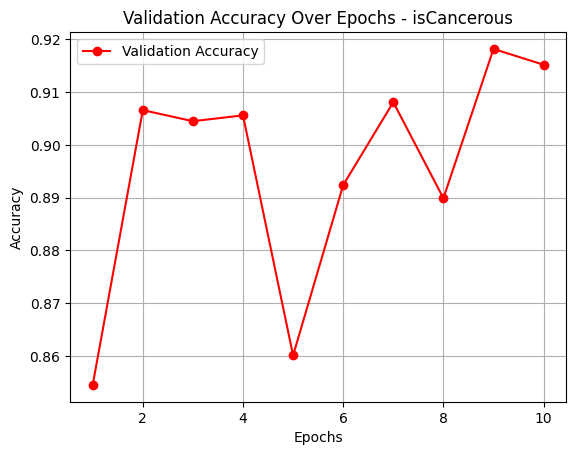

In [18]:
# Replace with your actual validation accuracy values
val_acc = [0.8545, 0.9066, 0.9045, 0.9056, 0.8601, 0.8924, 0.9081, 0.8899, 0.9182, 0.9152]

epochs = range(1, len(val_acc) + 1)

plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Validation Accuracy Over Epochs - isCancerous')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Observations:

The validation accuracy fluctuates, but generally stays high (mostly above 0.89).

There's a dip at epoch 5, but it recovers quickly and peaks at epoch 9 (0.918).

There’s no clear downward trend, which suggests the model is not heavily overfitting.

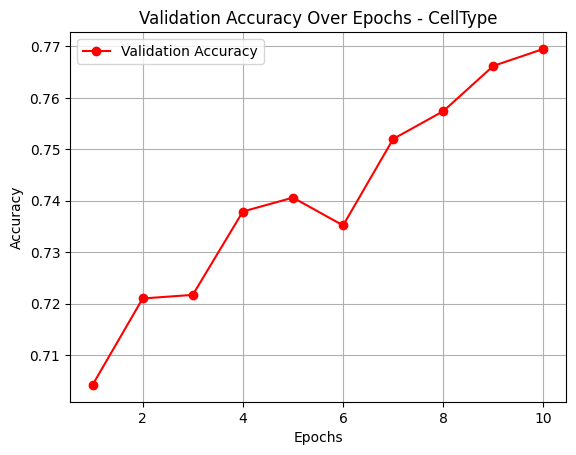

In [19]:
# Replace with your actual validation accuracy values
val_acc = [0.7042, 0.7210, 0.7217, 0.7379, 0.7406, 0.7352, 0.7520, 0.7574, 0.7662, 0.7695]

epochs = range(1, len(val_acc) + 1)

plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Validation Accuracy Over Epochs - CellType')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Observations:

Validation accuracy consistently increases from ~0.705 to ~0.769 over 10 epochs.

No sudden drops or signs of instability.

Accuracy improves gradually, suggesting the model is still learning and generalizing.